In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as st
import math
import seaborn as sns
import statsmodels.api as sm
from pmdarima.utils import plot_acf
from scipy.optimize import minimize
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

In [151]:
df = pd.read_excel("data/Nile.xlsx", index_col=0)
df.tail()
# df.Nile.copy().to_list()

,Nile
1966,746
1967,919
1968,718
1969,714
1970,740


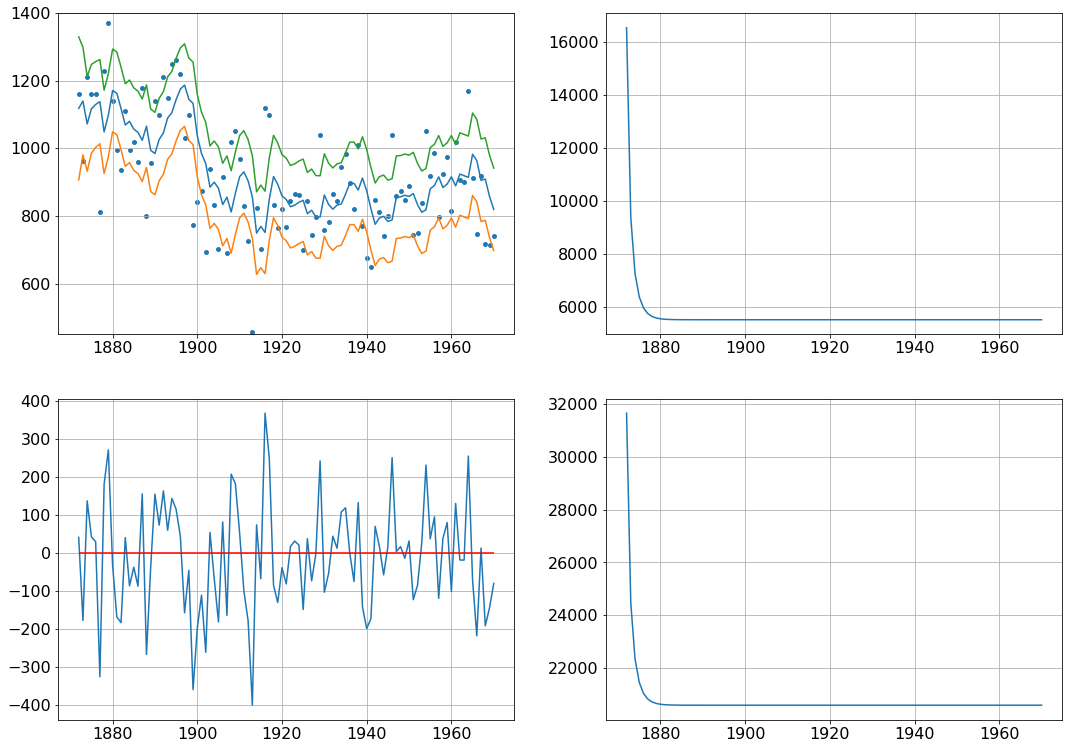

In [175]:
def Kalman_filter(series:pd.Series, P1:float, a1:float, s2_e:float, s2_n:float):
    t_crit = 1.6448
    y_list = series.copy().to_list()
    r = pd.DataFrame(columns=['a', 'P', 'v', 'F', 'K', 'ci'])
    
    a = a1
    P = P1
    
    for i,y in enumerate(y_list):
        
        # compute all variables
        v = y - a
        F = P + s2_e
        K = P/F

        # store result for t=i
        r.loc[i] = [a, P, v, F, K, (t_crit * P**.5)]
        
        if np.isnan(y):
            # filter (nowcasting)
            a_f = a
            P_f = P
            # predict step
            a_p = a
            P_p = P + s2_n

        else:
            #filtering
            a_f = a + K * v
            P_f = P * (1 - K)
            #predict step + 1
            a_p = a_f
            P_p = P_f + s2_n

        # store prediction t+1 for next iteration
        a = a_p
        P = P_p

    r["y"] = series.values
    r.index = series.index
    return r

df_kf = Kalman_filter(series = df.Nile, P1=1e7, a1=0, s2_e = 15099, s2_n = 1469.1)
df_kf = df_kf.iloc[1:]

fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.scatter(df_kf.index, df_kf.y, s=15)
df_kf.a.plot(ax=ax)
(df_kf.a-df_kf.ci).plot(ax=ax)
(df_kf.a+df_kf.ci).plot(ax=ax)
ax.set_ylim(450, 1400)

# lower left
ax = axs[1,0]
ax.plot(df_kf.index, df_kf.v)
ax.hlines(y = 0, xmin= df_kf.index.min(), xmax=df_kf.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_kf.index, df_kf.P)


# lower right
ax = axs[1,1]
ax.plot(df_kf.index, df_kf.F)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass
plt.savefig('fig1.png', bbox_inches='tight')


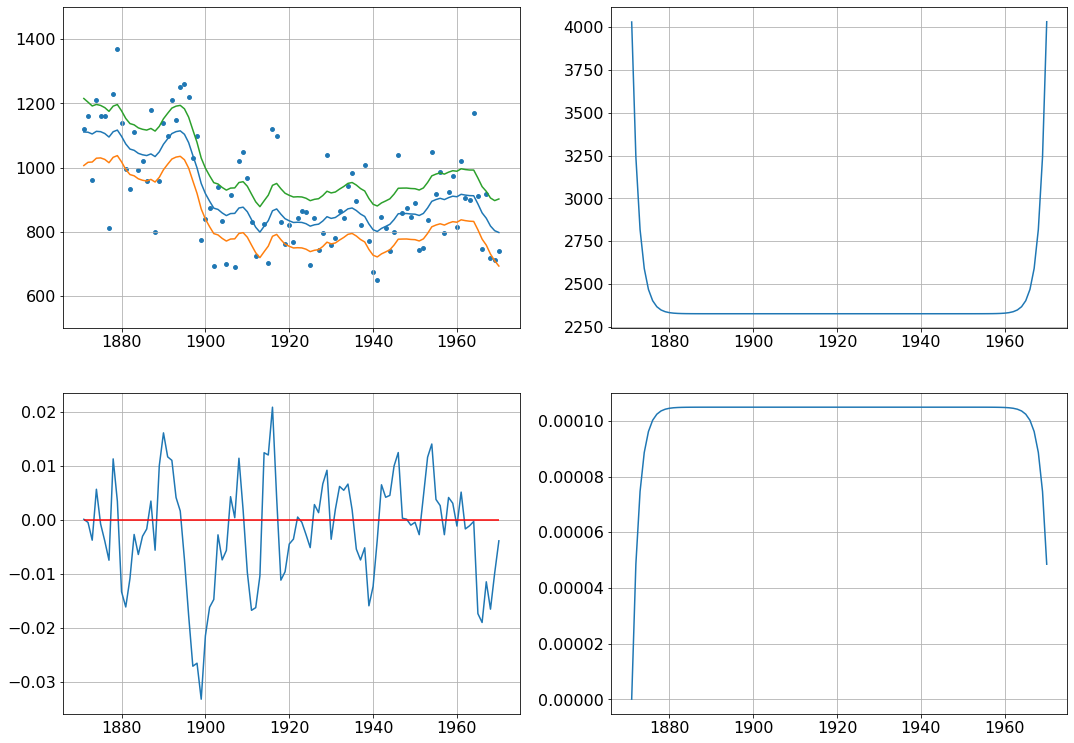

In [176]:
def Kalman_smoother(y: pd.Series, P1: float, a1: float, s2_e: float, s2_n: float, r_n: float, N_n: float):
    df_kf = Kalman_filter(y, P1, a1, s2_e, s2_n)
    ind = df_kf.index
    t_crit = 1.644
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'a', 'N', 'V', 'err'])

    r = r_n
    N = N_n
    
    for i, row in df_kf.iterrows():
        
        if np.isnan(row['y']):
            r = r
            N = N
        else:
            r = row['F']**-1 * row['v'] + (1-row['K'])*r
            N = row['F']**-1 + (1-row['K'])**2 * N

        a = row['a'] + row['P']*r
        V = row['P'] - row['P']**2 * N

        df_ks.loc[i] = [r, a, N, V, t_crit*V**0.5]
        
    # store existing data
    df_ks["y"] = df_kf["y"]
    add_columns = [c for c in df_kf.columns if c not in df_ks.columns]
    df_ks[add_columns] = df_kf[add_columns]

    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    df_ks.index = ind
    return df_ks

df_ks = Kalman_smoother(y=df.Nile, P1=10**7, a1=0, s2_e = 15099, s2_n = 1469.1, r_n = 0, N_n = 0)
fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.scatter(df.index, df.Nile, s=15)
ax.plot(df_ks.index, df_ks.a)
ax.plot(df_ks.index, df_ks.a-df_ks.err)
ax.plot(df_ks.index, df_ks.a+df_ks.err)
ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df_ks.index, df_ks.r)
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ks.index, df_ks.V)


# lower right
ax = axs[1,1]
ax.plot(df_ks.index, df_ks.N)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass
plt.savefig('fig2.png', bbox_inches='tight')

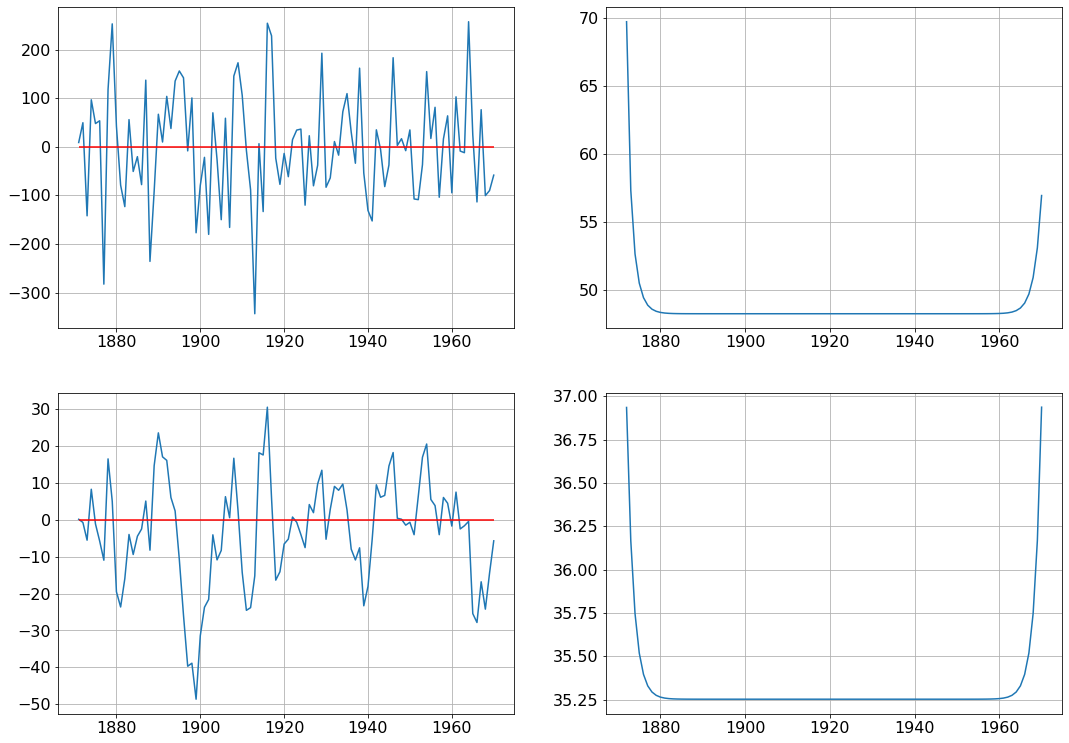

In [177]:
def dist_smoothing(y: pd.Series, P1, a1, s2_e, s2_n, r_int, N_int):
    ind = y.index
    series = y.copy().to_list()
    df_kf = Kalman_filter(y, P1,a1, s2_e, s2_n)
    df_ks = Kalman_smoother(y, P1, a1, s2_e, s2_n, r_int, N_int)
    df_ds = pd.DataFrame(columns=['eps', 'n', 'var_eps', 'var_n', 'D'])

    for i, row in df_ks.iterrows():

        eps = row.y - row.a

        D = row.F**(-1) + row.K**2 * row.N
        var_eps = s2_e - s2_e**2 * D
        var_n = s2_n - s2_n**2 * row.N
        n = s2_n * row.r
        
        df_ds.loc[i] = [eps, n, var_eps, var_n, D]

    df_ds.index = df_ks.index
    df_ds["y"] = df_ks["y"]

    return df_ds

df_ds = dist_smoothing(y=df.Nile, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0)
fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.plot(df_ds.index, df_ds['eps'])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# lower left
ax = axs[1,0]
ax.plot(df_ds.index, df_ds['n'])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ds.index[1:], df_ds['var_eps'][1:]**0.5)


# lower right
ax = axs[1,1]
ax.plot(df_ds.index[1:], df_ds['var_n'][1:]**0.5)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass
plt.savefig('fig3.png', bbox_inches='tight')


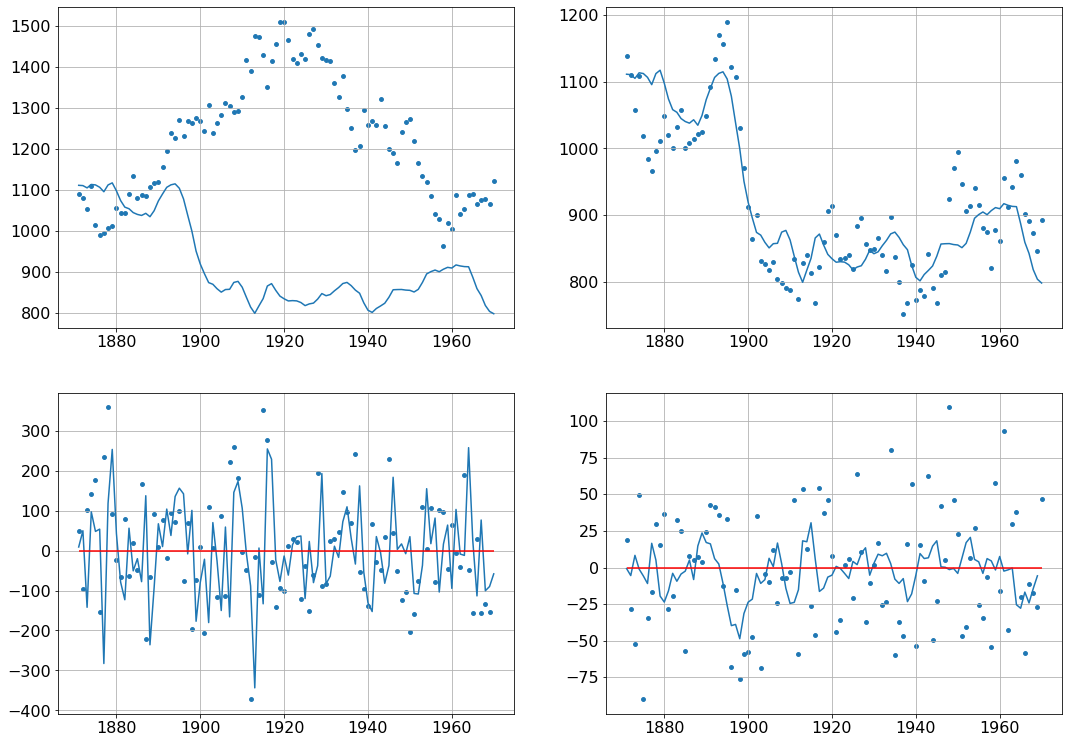

In [178]:
def llm_sim(df, P1, a1, s2_e, s2_n, r_int, N_int, a1_plus):

    df_kf = Kalman_filter(df.Nile, P1, a1, s2_e, s2_n)
    df_ks = Kalman_smoother(df.Nile, P1, a1, s2_e, s2_n, r_int, N_int)
    df_ks["eps"] = df_ks.y - df_ks.a
    df_ds = dist_smoothing(df.Nile, P1, a1, s2_e, s2_n, r_int, N_int)
    
    # draw sample
    eps_list = np.random.randn(len(df)) * np.sqrt(s2_e)
    eta_list = np.random.randn(len(df)) * np.sqrt(s2_n)
    df_sim = pd.DataFrame({
        "eps_sim": eps_list,
        "eta_sim": eta_list,
        "y_sim": a1_plus + np.cumsum(eta_list) + eps_list,
        "a_sim": a1_plus + np.cumsum(eta_list)
    })
    
    df_sim_ks = Kalman_smoother(df_sim.y_sim, P1, a1, s2_e, s2_n, r_int, N_int)

    a = a1_plus
    a_prev = a1_plus
    df_llm = pd.DataFrame(columns=['alpha_kringeltje', 'eps_kringeltje', 'eta_kringeltje'])
    for i, y in enumerate(df.Nile.to_list()):

        # draw random variables
        row_ks = df_sim_ks.loc[i]
        eps_sim_est = row_ks.y - row_ks.a
        eps_sim = eps_list[i]

        # eps_kringeltje = eps - 
        eps_kringeltje = eps_sim - eps_sim_est + df_ks.iloc[i]["eps"]
        a_kringeltje = y - eps_kringeltje
        
        eta_kringeltje = a_kringeltje - a_prev
        a_prev = a_kringeltje
        
        # store result
        df_llm.loc[i] = [a_kringeltje, eps_kringeltje, eta_kringeltje]
        
    # add true data to df
    df_llm["y"] = df.Nile.to_list()
    df_llm["eps_kringeltje"] = df_llm["eps_kringeltje"].shift(-1)
    df_llm.index = df.index
    
    # store simulation in df_llm
    df_llm["y_sim"] = df_sim["y_sim"].to_list()
    df_llm["a_sim"] = df_sim["a_sim"].to_list()
    return df_ks, df_llm

df_ks, df_llm = llm_sim(df=df, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0, a1_plus=df.Nile.values[0])

fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.scatter(df_llm.index, df_llm.a_sim, s=15)
ax.plot(df_ks.index, df_ks.a)

# lower left
ax = axs[1,0]
ax.plot(df_ks.index, (df_ks.y - df_ks.a))
ax.scatter(df_llm.index, df_llm.eps_kringeltje, s=15)
ax.hlines(y = 0, xmin= df_ks.index.min(), xmax=df_ks.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ks.index, df_ks.a)
ax.scatter(df_llm.index, df_llm.alpha_kringeltje, s=15)


# lower right
ax = axs[1,1]
ax.plot(df_ks.index, df_ks.a.diff().shift(-1))
ax.scatter(df_llm.index, df_llm.eta_kringeltje, s=15)
ax.hlines(y = 0, xmin= df_ks.index.min(), xmax=df_ks.index.max(), color = 'r', linestyle = '-')

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.savefig('fig4.png', bbox_inches='tight')

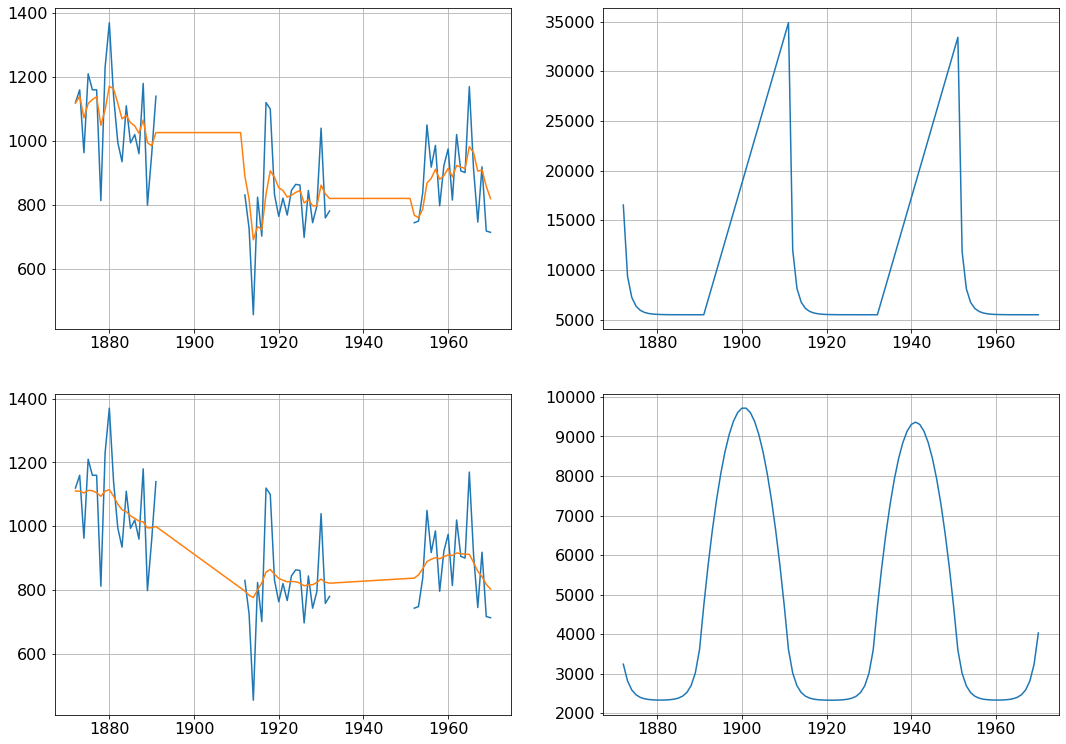

In [179]:
def missing_vals(df, P1, a1, s2_e, s2_n, r_n, N_n):

    df_mis = df.copy()
    ind = df_mis.index
    df_mis[(df_mis.index<df_mis.index[0]+40) & (df_mis.index>=df_mis.index[0]+20)] = np.nan
    df_mis[(df_mis.index<df_mis.index[0]+80) & (df_mis.index>=df_mis.index[0]+61)] = np.nan

    df_kf = Kalman_filter(series=df_mis.Nile, P1=P1, a1=a1, s2_e=s2_e, s2_n=s2_n)
    df_ks = Kalman_smoother(y=df_mis.Nile, P1=P1, a1=a1, s2_e=s2_e, s2_n=s2_n, r_n=r_n, N_n=N_n)

    df_mv = pd.DataFrame(columns=['Nile', 'a_f', 'P_f', 'alpha_s', 'V_s'])
    df_mv['Nile'] = df_mis.Nile
    df_mv['a_f'] = df_kf['a']
    df_mv['P_f'] = df_kf['P']
    df_mv['alpha_s'] = df_ks['a']
    df_mv['V_s'] = df_ks['V']

    df_mv.index = ind
    df_mv.loc[df_mv.index[0]] = [df_mv['Nile'][df_mv.index[0]], np.nan, np.nan, df_ks.a[df_mv.index[0]], np.nan]

    return df_mv

df_mv = missing_vals(df=df, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_n=0, N_n=0)

fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.plot(df_mv.index, df_mv.Nile.shift(1))
ax.plot(df_mv.index, df_mv.a_f)

# lower left
ax = axs[1,0]
ax.plot(df_mv.index, df_mv.Nile.shift(1))
ax.plot(df_mv.index, df_mv.alpha_s.shift(1))

# upper right
ax = axs[0,1]
ax.plot(df_mv.index, df_mv.P_f)

# lower right
ax = axs[1,1]
ax.plot(df_mv.index, df_mv.V_s)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.savefig('fig5.png', bbox_inches='tight')

Index(['a', 'P', 'v', 'F', 'K', 'ci', 'y'], dtype='object')


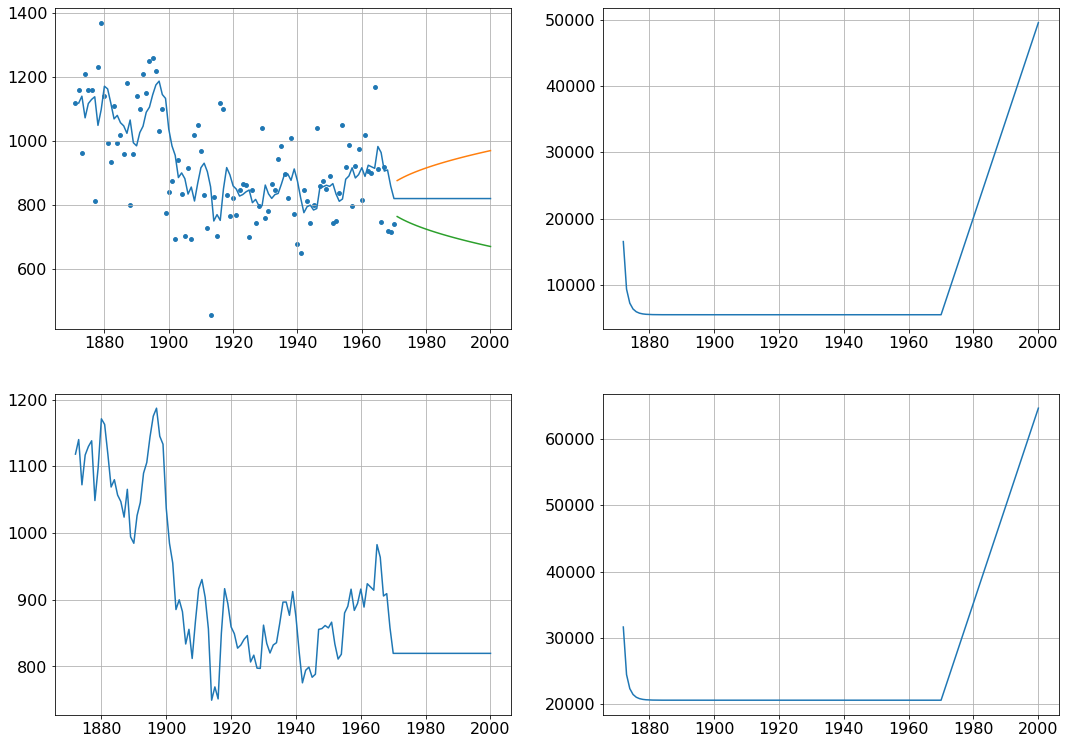

In [180]:
def Kalman_filter_forecast(series: pd.Series, P1, a1, s2_e, s2_n, T_pred):
    
    df_kf = Kalman_filter(df.Nile, P1, a1, s2_e, s2_n)
    row = df_kf.iloc[-1]
    print(df_kf.columns)

    a = row.a
    P = row.P
    
    t_start = df_kf.index.max() + 1
    t_end = t_start + T_pred
    
    for i in range(t_start, t_end):
        P += s2_n
        F = P + s2_e
        df_kf.loc[i] = [a, P, np.nan, F, np.nan, np.nan, np.nan]
    return df_kf.iloc[1:]
    
df_kf =  Kalman_filter_forecast(df.Nile, 1e7, 0, 15099, 1469.1, T_pred=30)

fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.scatter(df.index, df.Nile, s=15)
ax.plot(df_kf.index, df_kf.a)
df_pred = df_kf.copy().iloc[-30:]
t_crit = .674 # 50 percent, two sided z-value
ax.plot(df_pred.index, df_pred.a + t_crit * np.sqrt(df_pred.P))
ax.plot(df_pred.index, df_pred.a - t_crit * np.sqrt(df_pred.P))

# lower left
ax = axs[1,0]
ax.plot(df_kf.index, df_kf.a)

# upper right
ax = axs[0,1]
ax.plot(df_kf.index, df_kf.P)

# lower right
ax = axs[1,1]
ax.plot(df_kf.index, df_kf.F)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.savefig('fig6.png', bbox_inches='tight')


c:\Users\SF01053\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


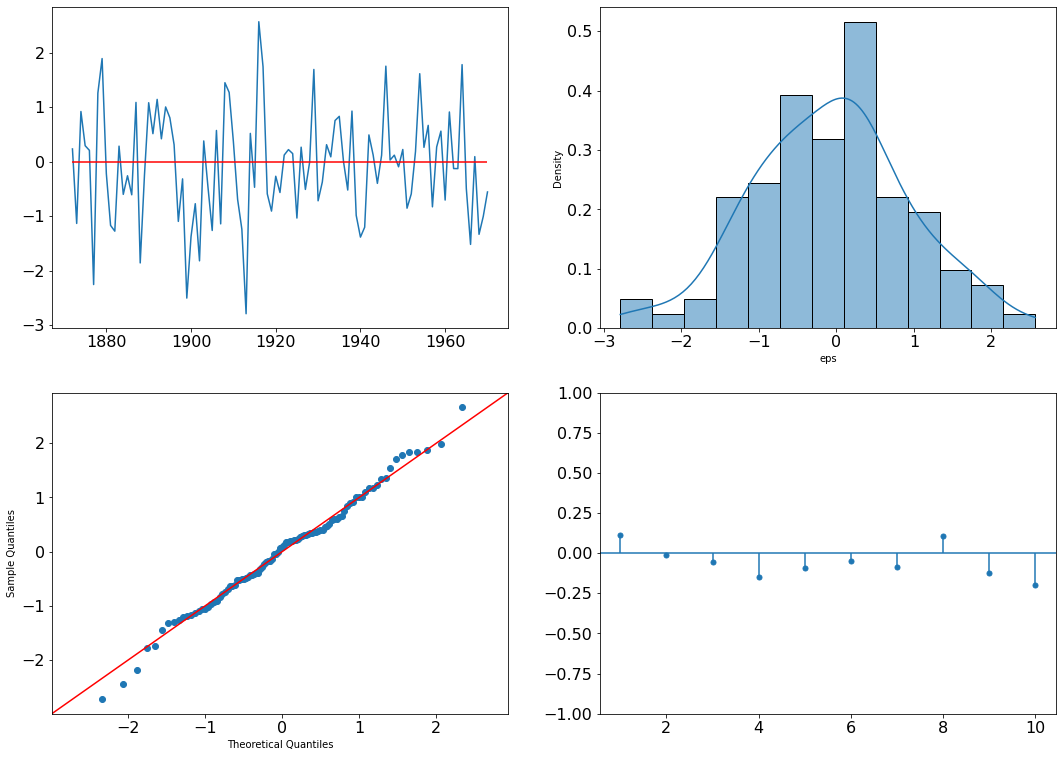

<Figure size 432x288 with 0 Axes>

In [183]:
def diagnostic(df, P1, a1, s2_e, s2_n, r_int, N_int):

    df_kf = Kalman_filter(series=df.Nile, P1=P1, a1=a1, s2_e=s2_e, s2_n=s2_n)
    df_ks = Kalman_smoother(y=df.Nile, P1=P1, a1=a1, s2_e=s2_e, s2_n=s2_n, r_n=r_int, N_n=N_int)
    df_ds = dist_smoothing(y=df.Nile, P1=P1, a1=a1, s2_e=s2_e, s2_n=s2_n, r_int=r_int, N_int=N_int)
    ind = df.index

    df_diag = pd.DataFrame(columns=['eps', 'u', 'r'])

    df_diag['eps'] = df_kf.v / df_kf.F**0.5
    df_diag['u'] = (df_kf.F**-1 * df_kf.v - df_kf.K * df_ks.r.shift(-1)) * df_ds.D**(-0.5)
    df_diag['r'] = df_ks.r * df_ks.N**(-0.5)
    # df_diag['u'] = df_ds.eps / df_ds.var_eps**0.5
    # df_diag['r'] = df_ds.n / df_ds.var_n**0.5
    df_diag.index = ind

    return df_diag

df_diag = diagnostic(df=df, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0)[1:]

fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.plot(df_diag.index, df_diag.eps)
ax.hlines(y = 0, xmin= df_diag.index.min(), xmax=df_diag.index.max(), color = 'r', linestyle = '-')

# lower left
# ax = axs[1,0]
sm.qqplot(df_diag.eps, line='45', ax=axs[1,0], fit=True)

# upper right
# ax = axs[0,1]
#ax.hist(df_diag.eps, bins=13, density=True)
sns.histplot(data=df_diag.eps, ax=axs[0,1], x=None, y=None, bins=13, kde=True, stat='density')


# lower right
# ax = axs[1,1]
plot_acf(df_diag.eps, ax=axs[1,1], lags=np.arange(1,11), title='')


# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.savefig('fig7.png', bbox_inches='tight')


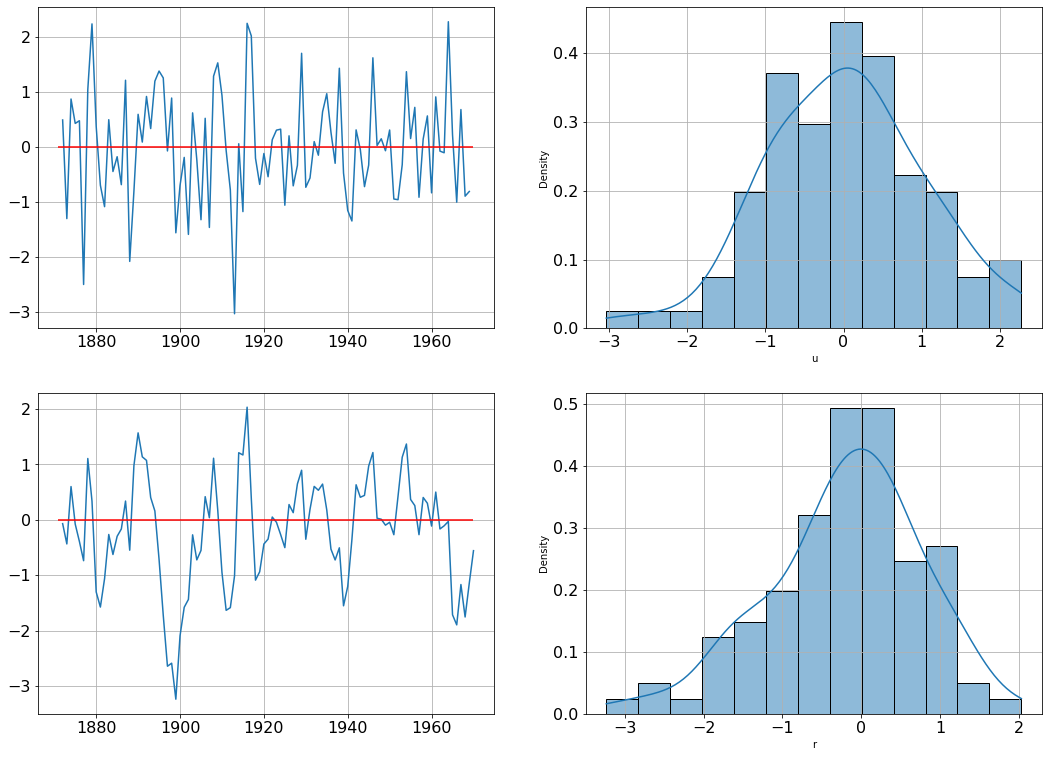

In [182]:
df_diag = diagnostic(df=df, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0)

fig, axs = plt.subplots(2,2, figsize=(18,13))

# upper left
ax = axs[0,0]
ax.plot(df_diag.index[1:], df_diag.u[1:])
ax.hlines(y = 0, xmin= df_diag.index.min(), xmax=df_diag.index.max(), color = 'r', linestyle = '-')

# lower left
ax = axs[1,0]
ax.plot(df_diag.index[1:], df_diag.r[1:])
ax.hlines(y = 0, xmin= df_diag.index.min(), xmax=df_diag.index.max(), color = 'r', linestyle = '-')

# upper right
sns.histplot(data=df_diag.u, ax=axs[0,1], x=None, y=None, bins=13, kde=True, stat='density')

# lower right
sns.histplot(data=df_diag.r, ax=axs[1,1], x=None, y=None, bins=13, kde=True, stat='density')

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.savefig('fig8.png', bbox_inches='tight')

In [185]:
def mle_kf(betas, dataframe):
    q = betas
    ll_df = pd.DataFrame(columns=['v', 'F_ster'])
    dataframe =dataframe.astype(float)
    a = dataframe.Nile[dataframe.index[1]]
    P_ster = 1 + q
    
    for i, y in enumerate(dataframe.Nile):
        if i >= 2:
            v = y - a
            F_ster = P_ster + 1

            K = P_ster/F_ster
            a = a + K * v
            P_ster = P_ster * (1 - K) + q
            

            ll_df.loc[i-2] = [v, F_ster]

    n = len(ll_df)
    sigma_kwadraat = (1/(n - 1)) * np.sum(ll_df.v**2/ll_df.F_ster)
    loglikelihood = -1 * (n/2)* np.log(2 * math.pi) - ((n - 1)/2) - ((n - 1)/2) * np.log(sigma_kwadraat) - 0.5 * np.sum(np.log(ll_df.F_ster))

    return loglikelihood

def minimize_ll(model, start_values, dataframe):
 
    values = minimize(fun=model, x0=start_values, args= dataframe, options={'maxiter':4})
    
    return values    

max_betas = minimize_ll(mle_kf, [1], df)

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method